<a href="https://colab.research.google.com/github/manishiitg/ML_Experiments/blob/master/autoencoder/VAE_ecommerce_pytorch_64x62_2_layer_ConVV_but_very_slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

fashion-product-images-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

with zipfile.ZipFile("./fashion-product-images-small.zip","r") as zip_ref:
  zip_ref.extractall("fashion-product-images-small")

In [25]:
import os
root = './fashion-product-images-small/images'
img_list = os.listdir(root)
print(img_list[:10])
print(len(img_list))

['38408.jpg', '38605.jpg', '20542.jpg', '28094.jpg', '20158.jpg', '55785.jpg', '54395.jpg', '2689.jpg', '52363.jpg', '18788.jpg']
44441


In [26]:
import torch
import torch.nn as nn
import torchvision  
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [0]:
import PIL.Image as Image


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ToPILImage(),
     transforms.Resize(size=(64, 64), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 256
celeba_data = datasets.ImageFolder('./fashion-product-images-small', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

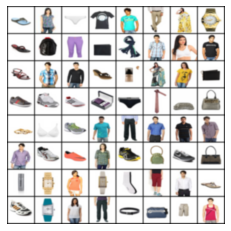

In [28]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

batch, _ = next(iter(data_loader))
show(batch[0:64], renorm = True, nrow=8)

In [29]:
class Flatten(nn.Module):
    def forward(self, input):
      return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=2304):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=2304, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2, padding=0),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, z_dim, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(z_dim, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        # print(h.shape, "bottleneck shape")
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        # print(x.shape, "input shape")
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        # print(z.shape, "output shape")
        return z, mu, logvar

model = VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        images = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(images)
        loss = loss_fn(recon_batch, images, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_loader.dataset)))

train(1)

Train Epoch: 1 [0/88882 (0%)]	Loss: 8636.910156
Train Epoch: 1 [25600/88882 (29%)]	Loss: 4855.395996
Train Epoch: 1 [51200/88882 (57%)]	Loss: 4995.768066
Train Epoch: 1 [76800/88882 (86%)]	Loss: 4921.281250
====> Epoch: 1 Average loss: 5196.6258


In [30]:
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

print(outputSize(32,4,2,0))

15


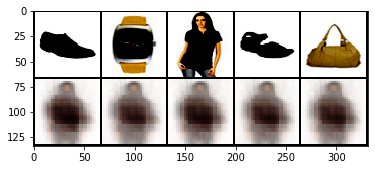

In [31]:
from torch.utils.data import RandomSampler
from torchvision.utils import save_image
import matplotlib.image as mpimg


def test(epoch):
  random_sampler = RandomSampler(data_loader)
  test_loader = DataLoader(celeba_data,batch_size=batch_size ,sampler=random_sampler)
  batch, _ = next(iter(test_loader))
  model.eval()
  recon_batch, _, _  = model(batch)

  epoch = 1
  n = 5

  comparison = torch.cat([batch[:n],recon_batch[:n]])

  save_image(comparison.cpu(),'reconstruction_ecommerce' + str(epoch) + '.png', nrow=n)
                  
  plt.imshow(mpimg.imread('reconstruction_ecommerce' + str(epoch) + '.png'), aspect=True)

test(1)

In [0]:
for epoch in range(1, 20):
        train(epoch)
        

test(epoch)


In [0]:
with torch.no_grad():
    sample = torch.randn(64, 64).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 3, 64, 64),
                'sample_' + str(epoch) + '.png')
    plt.imshow(mpimg.imread('sample_' + str(epoch) + '.png'))
    # show(sample, renorm = True, nrow=8)